# Modeling Covid Cases and Deaths with Python by Ted Petrou

**Topics**

* Dashboard Overview
* Data Smoothing
* Modeling with "S"-shaped curves
* Ensemble Modeling

## Dashboard Overview

* https://coronavirus.dunderdata.com

## Data Source

* https://github.com/CSSEGISandData/COVID-19
* cleaned
* cumulative

### Read in last 150 days of USA cases

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('dashboard.mplstyle')
pd.set_option('display.max_columns', None)

usa_cases = pd.read_csv('data/usa_cases.csv', index_col='date', parse_dates=['date']).iloc[-150:]
usa_cases.tail(3)

,Alabama,Alaska,American Samoa,Arizona,Arkansas,California,Colorado,Connecticut,Cruise Ship,Delaware,District of Columbia,Florida,Georgia,Guam,Hawaii,Idaho,Illinois,Indiana,Iowa,Kansas,Kentucky,Louisiana,Maine,Maryland,Massachusetts,Michigan,Minnesota,Mississippi,Missouri,Montana,Nebraska,Nevada,New Hampshire,New Jersey,New Mexico,New York,North Carolina,North Dakota,Northern Mariana Islands,Ohio,Oklahoma,Oregon,Pennsylvania,Puerto Rico,Rhode Island,South Carolina,South Dakota,Tennessee,Texas,Utah,Vermont,Virgin Islands,Virginia,Washington,West Virginia,Wisconsin,Wyoming
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-03-07,499819,59285,0,826454,324818,3599250,436612,285330,152,88354,41419,1944995,1023487,7749,28107,172931,1198257,667262,339672,298188,410709,433785,45794,387319,591356,656072,490011,297581,498008,100914,203026,296190,76861,812609,186922,1694651,872176,100391,145,978471,428997,157285,950773,101327,128121,525865,113589,783484,2695558,374850,16083,2714,585700,344532,133445,621654,54764
2021-03-08,500092,59624,0,827237,324951,3602380,437187,287396,152,88563,41579,1948307,1024931,7751,28148,173309,1199441,667736,340128,298788,411040,434289,45933,388035,592344,658355,490483,297651,498269,100959,203027,296393,77060,814916,187040,1700091,874906,100419,146,979725,429162,157515,952818,101327,128981,526716,113596,783904,2699083,375110,16199,2744,586592,345731,133627,621842,54903
2021-03-09,500616,59712,0,827800,325383,3607891,438025,288145,152,88679,41910,1952733,1026692,7752,28189,173790,1200938,668308,340891,298806,411917,434926,46066,388666,593607,659890,492108,298008,498663,101093,203279,296822,77252,819042,187238,1706924,875903,100514,146,981618,429432,158007,955743,101937,129277,527348,113753,785242,2704712,375669,16286,2744,588129,346403,133856,622444,54972


# Data Smoothing

In [2]:
texas = usa_cases['Texas']
texas.tail(3)

date
2021-03-07    2695558
2021-03-08    2699083
2021-03-09    2704712
Name: Texas, dtype: int64

### Cumulative graph

* looks smooth

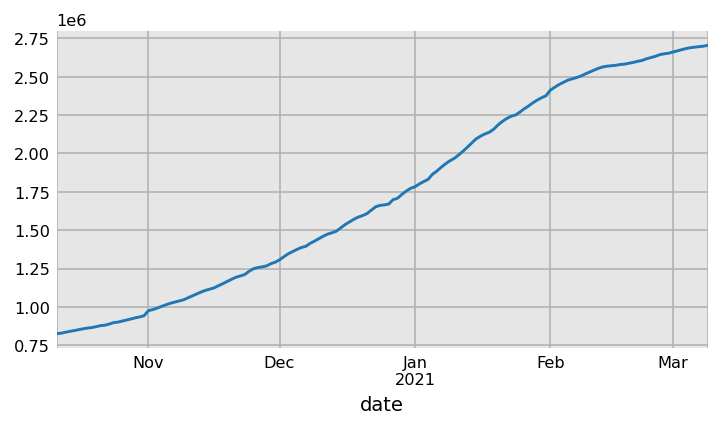

In [3]:
texas.plot();

### Daily graph

* not smooth
* reporting oddities

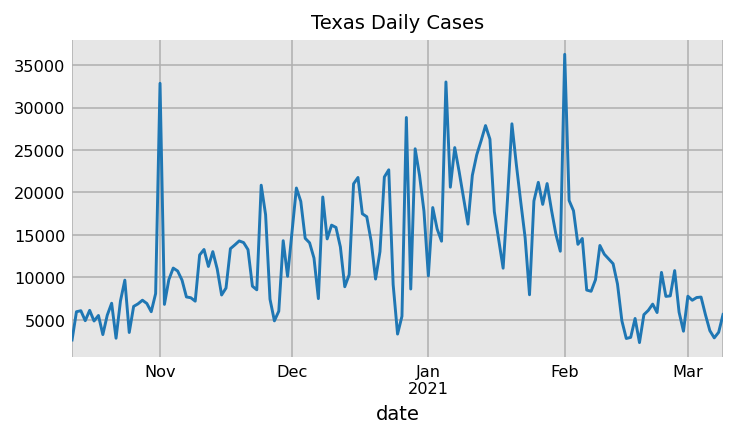

In [4]:
texas_daily = texas.diff().dropna()
texas_daily.plot(title='Texas Daily Cases');

### Smoothing techniques

* rolling average
* lowess

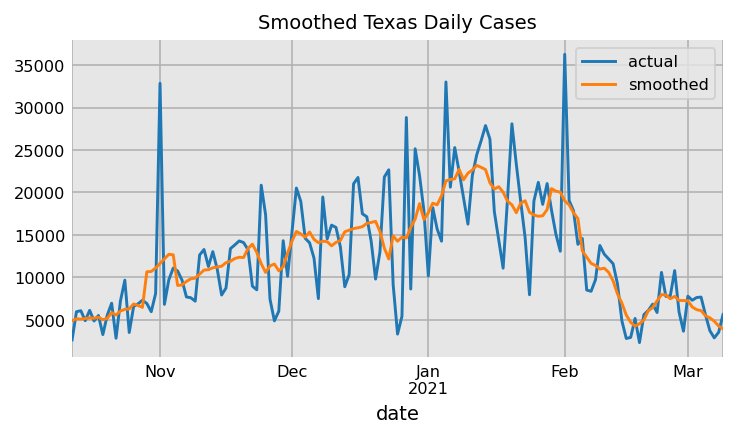

In [5]:
texas_daily.plot(label='actual');
texas_smoothed = texas_daily.rolling(7, min_periods=1, center=True).mean()
texas_smoothed.plot(title='Smoothed Texas Daily Cases', label='smoothed').legend();

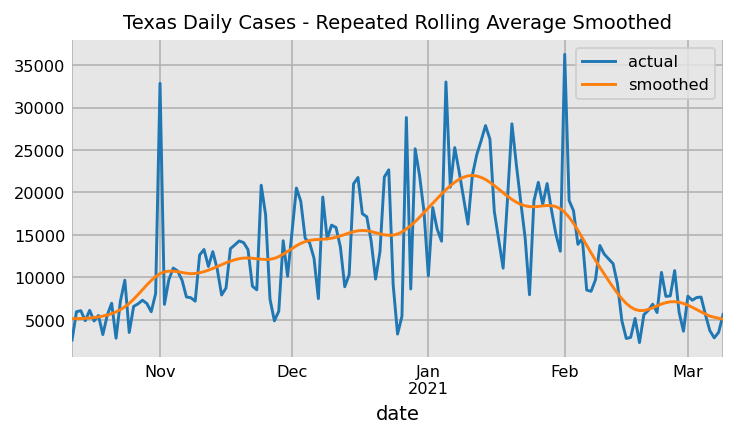

In [6]:
for i in range(3):
    texas_smoothed = texas_smoothed.rolling(7, min_periods=1, center=True).mean()

texas_daily.plot(label='actual')
texas_smoothed.plot(title='Texas Daily Cases - Repeated Rolling Average Smoothed', label='smoothed').legend();

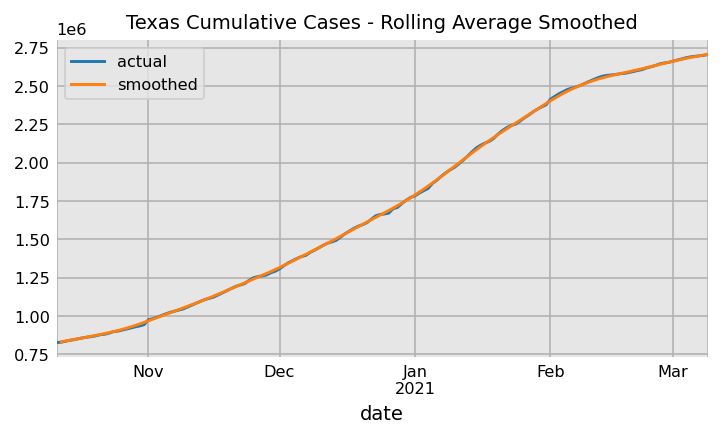

In [7]:
texas_cumulative_smoothed = texas_smoothed.cumsum() + texas.iloc[0]
texas.plot(label='actual', title='Texas Cumulative Cases - Rolling Average Smoothed')
texas_cumulative_smoothed.plot(label='smoothed').legend();

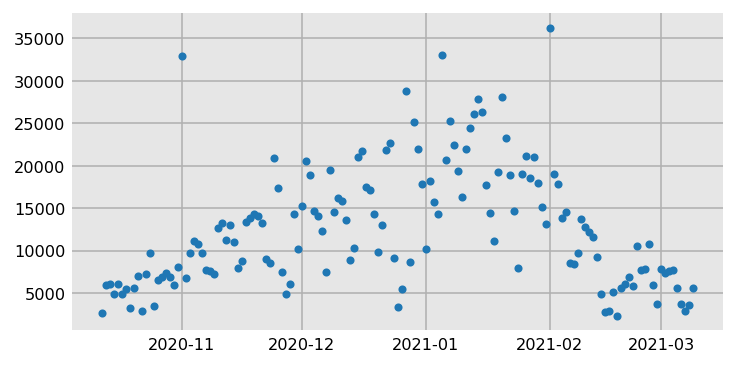

In [8]:
plt.scatter(texas_daily.index, texas_daily.values, s=10);

### Lowess

Locally weighted scatter plot smoothing

* A linear regression line is fit to each point using the nearest (local) points
* Points are weighted by distance to current point
* Choose number of points with `frac`

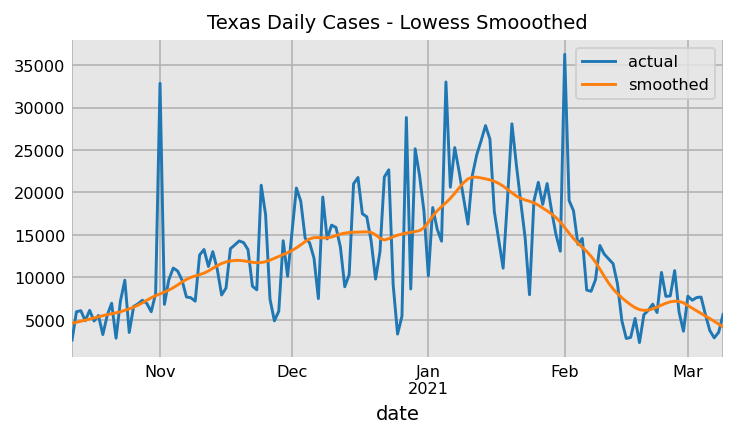

In [13]:
from statsmodels.nonparametric.smoothers_lowess import lowess

n = len(texas_daily)
x = np.arange(n)
y = texas_daily.values

frac = 20 / n
y_lowess = lowess(y, x, frac=frac, return_sorted=False)
texas_daily_lowess = pd.Series(y_lowess, index=texas_daily.index)
texas_daily.plot(label='actual')
texas_daily_lowess.plot(label='smoothed', title="Texas Daily Cases - Lowess Smooothed").legend();

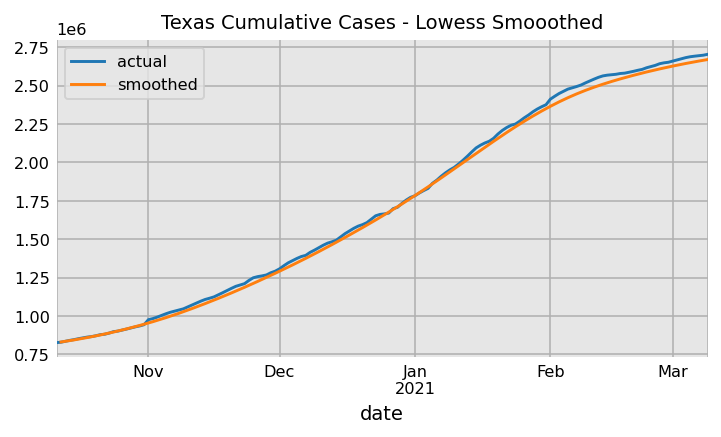

In [12]:
texas_cumulative_lowess = texas_daily_lowess.cumsum() + texas.iloc[0]
texas.plot(label='actual')
texas_cumulative_lowess.plot(label='smoothed', title="Texas Cumulative Cases - Lowess Smooothed").legend();

## Modeling with "S"-shaped curves

* Only modeling with historical data
* Modeling cumulative
* [Sigmoid functions](https://en.wikipedia.org/wiki/Sigmoid_function)

$$f(x) = \frac{1}{1 + e^x}$$

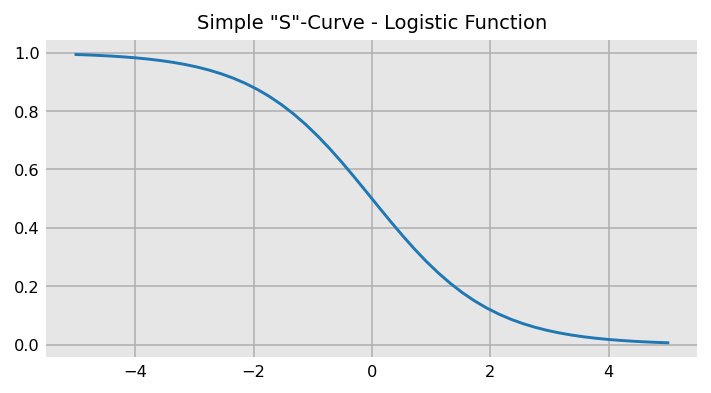

In [14]:
x = np.linspace(-5, 5, 50)
y = 1 / (1 + np.exp(x))
fig, ax = plt.subplots()
ax.plot(x, y)
ax.set_title('Simple "S"-Curve - Logistic Function');

Correct shape, needs to be transposed around y axis

$$f(x) = \frac{1}{1 + e^{-x}}$$

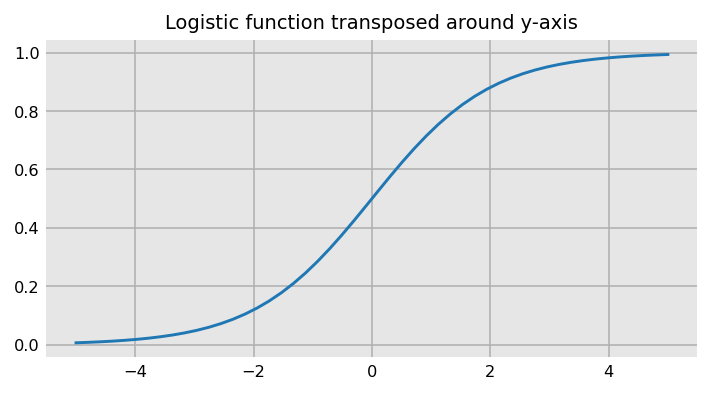

In [15]:
x = np.linspace(-5, 5, 50)
y = 1 / (1 + np.exp(-x))
plt.plot(x, y)
plt.title('Logistic function transposed around y-axis');

Increase maximum

$$f(x) = \frac{L}{1 + e^{-x}}$$

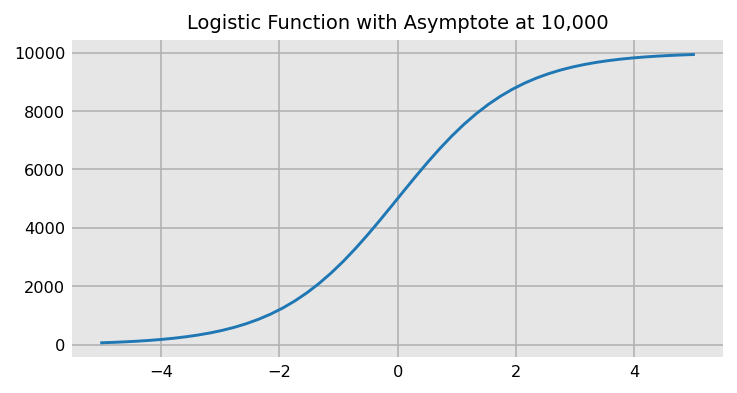

In [16]:
L = 10_000
x = np.linspace(-5, 5, 50)
y = L / (1 + np.exp(-x))
plt.plot(x, y)
plt.title(f'Logistic Function with Asymptote at {L:,}');

Allow horizontal shift, $x_0$ is middle, inflection point.

$$f(x) = \frac{L}{1 + e^{-(x - x_0)}}$$

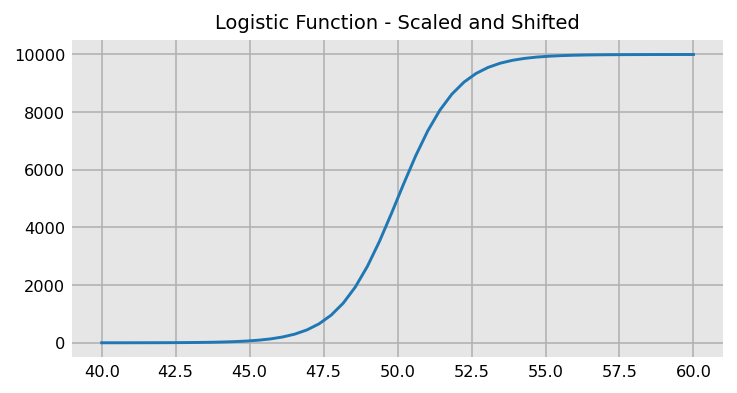

In [17]:
L = 10_000
x0 = 50
x = np.linspace(40, 60)
y = L / (1 + np.exp(-(x - x0)))
plt.plot(x, y)
plt.title('Logistic Function - Scaled and Shifted');

Allow for different growth rate (steepness)

$$f(x) = \frac{L}{1 + e^{-k(x - x_0)}}$$

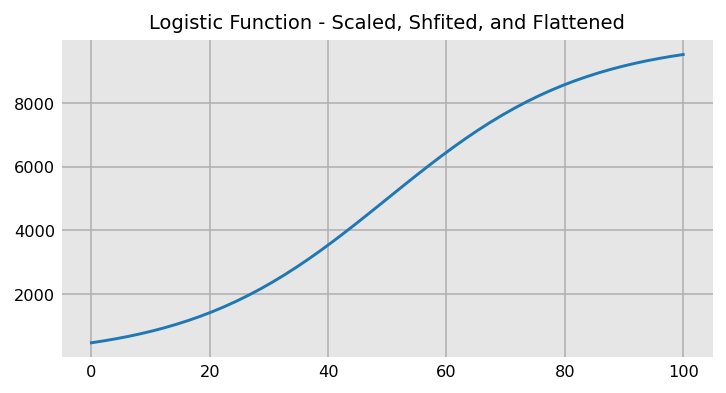

In [18]:
L = 10_000
x0 = 50
k = 0.06
x = np.linspace(0, 100, 50)
y = L / (1 + np.exp(-k * (x - x0)))
plt.plot(x, y)
plt.title('Logistic Function - Scaled, Shfited, and Flattened');

In [19]:
def logistic(x, L, x0, k):
    return L / (1 + np.exp(-k * (x - x0)))

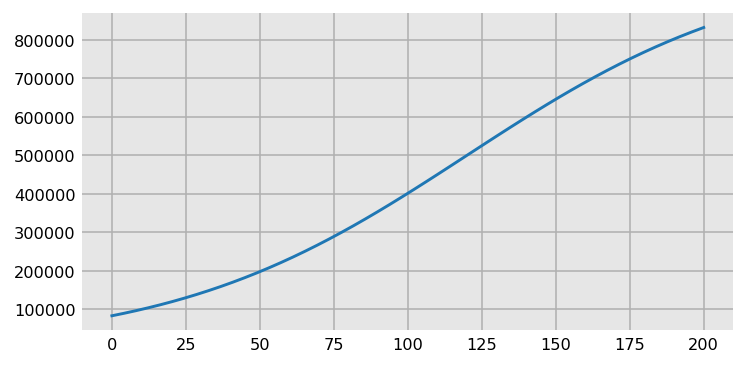

In [28]:
x = np.linspace(0, 200)
y = logistic(x, 1_000_000, 120, .02)
plt.plot(x, y);

### Manually fit logistic function to data?

In [29]:
y_texas = texas_cumulative_lowess
def manual_fit(y, func, params):
    n = len(y)
    x = np.arange(n)
    y_model = func(x, *params)
    y_model = pd.Series(y_model, index=y.index)
    y.plot(label='actual')
    y_model.plot(label='model').legend()

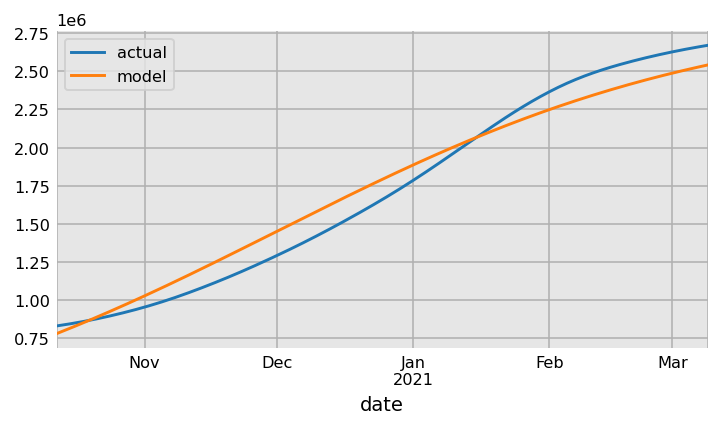

In [30]:
params = 2_900_000, 50, .02
manual_fit(y_texas, logistic, params)

### Scipy's optimize module

* Use `least_squares` function - finds parameters that minimize squared residuals
* Create optimization function that computes residuals
* Must create bounds for parameters
* Must have initial guess for parameters

In [31]:
def optimize_func(params, x, y, model):
    y_pred = model(x, *params)
    error = y - y_pred
    return error

In [32]:
from scipy.optimize import least_squares

# bounds for parameters L, x0, and k
lower = y_texas.iloc[-1], 20, 0.01
upper = 4_000_000, 150, 0.5
bounds = lower, upper

# initial guess for L, x0, and k
p0 = 3_000_000, 50, 0.1

# run with verbose
y = y_texas.values
x = np.arange(len(y))
res = least_squares(optimize_func, p0, args=(x, y, logistic), bounds=bounds, verbose=2)

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         3.9791e+13                                    5.68e+13    
       1              2         9.1306e+12      3.07e+13       1.87e+05       1.84e+13    
       2              3         1.4877e+12      7.64e+12       4.62e+04       4.59e+12    
       3              4         6.5539e+11      8.32e+11       7.41e+04       2.42e+12    
       4              5         3.9106e+11      2.64e+11       3.08e+05       6.10e+13    
       5              6         2.3771e+11      1.53e+11       1.65e+05       7.23e+12    
       6              7         2.0218e+11      3.55e+10       1.49e+05       6.46e+12    
       7              8         1.8675e+11      1.54e+10       1.42e+05       4.61e+12    
       8              9         1.8315e+11      3.60e+09       7.35e+04       9.38e+11    
       9             10         1.8227e+11      8.77e+08       5.13e+04       3.84e+11    

Fitted parameters are in `x` attribute

In [33]:
res.x

array([3.74982515e+06, 8.51780733e+01, 1.67854394e-02])

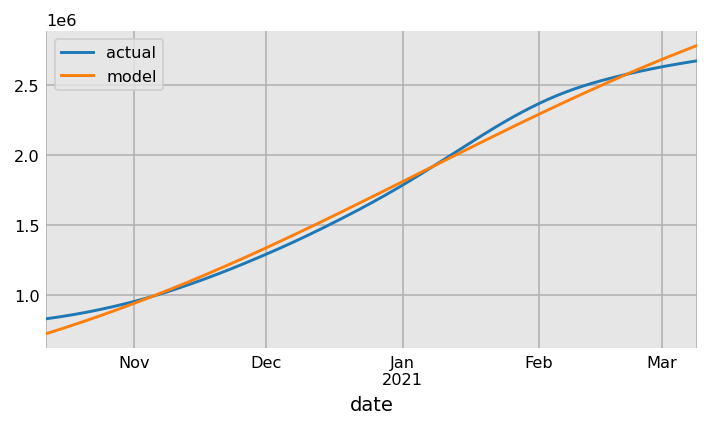

In [34]:
manual_fit(y_texas, logistic, res.x)

## Generalized Logistic Function

* [Asymmetric logistic function][0] - tail slowly trails off
* Also allow for vertical shift


$$f(x) = \frac{L - s}{(1 + e^{-kx})^{\frac{1}{v}}} + s$$

[0]: https://en.wikipedia.org/wiki/Generalised_logistic_function

In [35]:
def general_logistic_shift(x, L, k, v, s):
    return (L - s) / ((1 + np.exp(-k * x)) ** (1 / v)) + s

# bounds
lower = y_texas.iloc[-1], 0.01, 0.01, 0
upper = 4_000_000, 0.5, 1, y_texas.iloc[-1]
bounds = lower, upper

# initial guess for L, k, v, s
p0 = 3_000_000, 0.1, 0.1, y_texas.iloc[-1]

# run with verbose
y = y_texas.values
x = np.arange(len(y))
res = least_squares(optimize_func, p0, args=(x, y, general_logistic_shift), bounds=bounds, verbose=2)

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.3272e+14                                    1.39e+14    
       1              2         1.4973e+13      1.18e+14       1.18e+06       5.81e+13    
       2              3         9.7572e+11      1.40e+13       3.58e+05       8.70e+12    
       3              4         3.7214e+11      6.04e+11       1.37e+05       4.42e+13    
       4              6         2.4231e+11      1.30e+11       3.91e+04       4.54e+13    
       5              7         1.2702e+11      1.15e+11       7.94e+04       3.08e+13    
       6              8         9.2395e+10      3.46e+10       1.48e+05       7.26e+13    
       7              9         4.3163e+10      4.92e+10       5.06e+04       1.94e+12    
       8             10         4.0073e+10      3.09e+09       7.31e+04       1.20e+13    
       9             11         3.9083e+10      9.91e+08       7.28e+03       8.57e+09    

In [36]:
res.x

array([3.09593846e+06, 2.35572536e-02, 1.67280465e-01, 8.22521910e+05])

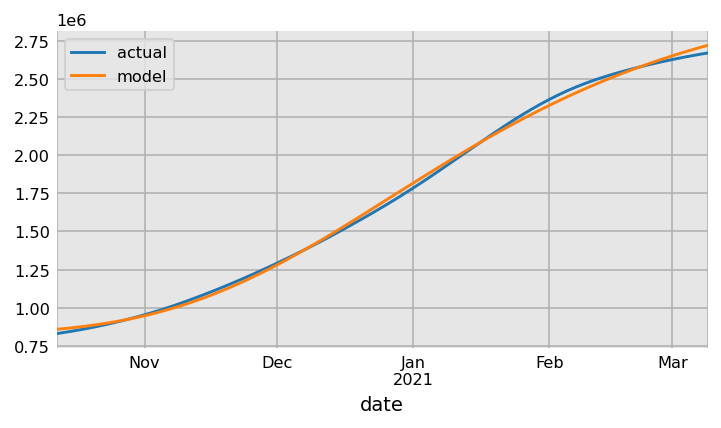

In [37]:
manual_fit(y_texas, general_logistic_shift, res.x)

## Modeling Deaths

* Could do same thing
* Use historical case fatality rate (fraction of cases that lead to death)

## Ensembling and modeling new waves

* Modeling new waves
    * Could model `L` as a Logistic function itself (many parameters)
    * Only allow model to see n previous days
    * Choose many different values of n and average result